# 3-D Segmentation Network Toy Problem Testing

This notebook loads a trained 3-D Segmentation network and test it against a random volume.

In [1]:
# Enviroment reset
%reset  
# matplotlib plots within notebook
%matplotlib inline



# Package importing
import numpy as np
import matplotlib.pyplot as plt

from mayavi import mlab
import pylab

from collections import OrderedDict

import dicom as dicom
import scipy
from scipy import stats
from scipy import ndimage
from skimage import restoration
from skimage import filters
from skimage import exposure
from skimage import morphology
from skimage import segmentation
from skimage import measure



# Custom packages
import sys
sys.path.insert(0, '../Librerias/Segm_Net_3D')

import Geometrias_3D as geo3D
import Segm_net_3D as segm3D

# Tensor Flow
import tensorflow as tf
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
# sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess = tf.InteractiveSession()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Re-build of previously trained network

### Variable Loading

In [2]:
# Path to checkpoint
CHECKPOINT_PATH = "../Salidas/Segm_Net_3D_Full/Segm_Net_3D.ckpt"


# --- Network parameters

# Imput volume size
voxels_X = 128
voxels_Y = 128
voxels_Z = 32
input_size = (voxels_X,voxels_Y,voxels_Z)
# Cube fileter size of convolution layers
size_filt_fine = (3, 3, 3) 
# Cube fileter size of last output layer
size_filt_out = (1, 1, 1) 
# Down-sample cube filter size
size_filt_down = (2, 2, 2) 
# Up-mple clube filter size
sizet_up = (2, 2, 2) 
# Imput channels, only one intensity volume
input_size_1 = 1
# Output channels, one per class plus background
num_clases = 6+1
# Volume color depth in this case is a single channel (intensity image)
input_channels = 1
# Network input placeholder
ph_entry = tf.placeholder(tf.float32)
# Network state placeholder (Train or Test)
phase = tf.placeholder(tf.bool)
# Depth of the network, hoy many down-convolutions will take place before the base level
network_depth = 4
# Channels to apply at each level in the down-ward path
net_channels_down = [16, 32, 64, 128]
# Channels to apply at base level
net_channels_base = [256]
# Channels to apply at each level in the up-ward path
net_channels_up = [16, 32, 64, 128]
# Channels to apply at segmentation/output level
net_channels_segm = [1]
# Convolutional layers to apply at each level in the down-ward path
net_layers_down = [2, 2, 2, 2]
# Convolutional layers to apply at base level
net_layers_base = [2]
# Convolutional layers to apply at each level in the up-ward path
net_layers_up = [1, 2, 2, 2]


# --- Volume generation parameters

# Noise to be added
noise_max = 0.15;
# Amount of elements to be inserted in the volume
Elements_number = 10
# Margins of volume to be left unpopulated
margins = (12,12,12,12,2,2)
# Size range of objects
object_size_range = (6,12)
# Transparency range of objects
object_transp_range = (0.6,0.95)
# Gauss filtering parameter
gauss_sigma = 0.5
# Class learned (0 for multi-class)
class_learn = 0


### Network Construction

In [3]:
# Network assembly

net_out = segm3D.Assemble_Network(ph_entry, phase, input_size, input_channels, num_clases, size_filt_fine, size_filt_out, network_depth, net_channels_down, net_layers_down, net_channels_base, net_layers_base, net_channels_up, net_layers_up, net_channels_segm)


## Checkpoint Load

In [4]:
saver = tf.train.Saver()

saver.restore(sess, CHECKPOINT_PATH)

## Test 

Here a random volume is created and it is computed throug the created network. The output of the network is a 6 channel, softmaxed, tensor of the same size as the imput. In order to generate a binary mask a voxel search is performed, looking for the class with the maximum voxel value. There is also a custom bias to the background class, in the case where the class with the highgest probability do not separates from other class by a minimum amount.

In [31]:
# Minimun difference between classes to consider it valid
DIFF_LIM = 0.1

# Single volume random batch creation, used to test
batch_size_test = 1
# (batch_in, batch_label) = geo3D.fun_gen_batch(batch_size_test,
#                                                [voxels_X, voxels_Y, voxels_Z], 
#                                                noise_max, 
#                                                Elements_number, 
#                                                margins, 
#                                                object_size_range, 
#                                                object_transp_range, 
#                                                gauss_sigma,
#                                                class_learn)

void_volume = np.zeros((voxels_X, voxels_Y, voxels_Z))
(volume_in, volume_label) = geo3D.fun_poblar_vol_each(void_volume, 
                                                      margins, 
                                                      object_size_range, 
                                                      object_transp_range, 
                                                      noise_max, 
                                                      gauss_sigma,
                                                      2,
                                                      class_learn)

# We expand one dimension to maki it compatible whith the network imput
batch_in = np.expand_dims(volume_in, axis=0)
batch_label = np.expand_dims(volume_label, axis=0)

# Cast from double to int of the batch label
batch_label_int = batch_label.astype(int)

# Run the model to get the softmaxed output
Cube_out_soft = sess.run(net_out, {ph_entry:batch_in, phase: False})

# Run an "argmax" function to get the label of the most probable class
argumentos_max = tf.argmax(net_out,-1)
Cube_out_max_arg = sess.run(argumentos_max, {ph_entry:batch_in, phase: False})

# Create the binary mask output
Cube_out_max = np.zeros((batch_size_test,voxels_X, voxels_Y, voxels_Z,num_clases))

# Fill the mask with ones at the voxels that it is most pobable and fullfills the minimun difference criteria
dims = Cube_out_max.shape
for i in range(0,dims[0]):
    for j in range(0,dims[1]):
        for k in range(0,dims[2]):
            for l in range(0,dims[3]):
                # Check if the diference is high enough to keep it
                diff_min = 99
                for d in range(0,num_clases):
                    diff_act = (Cube_out_soft[i,j,k,l,Cube_out_max_arg[i,j,k,l]]-Cube_out_soft[i,j,k,l,d])
                    if ((diff_min > diff_act) and (d != Cube_out_max_arg[i,j,k,l])):
                        diff_min = diff_act
                
                if diff_min > DIFF_LIM:
                    Cube_out_max[i,j,k,l,Cube_out_max_arg[i,j,k,l]] = 1
                else:
                    Cube_out_max[i,j,k,l,0] = 1
                    

### Slice Plots

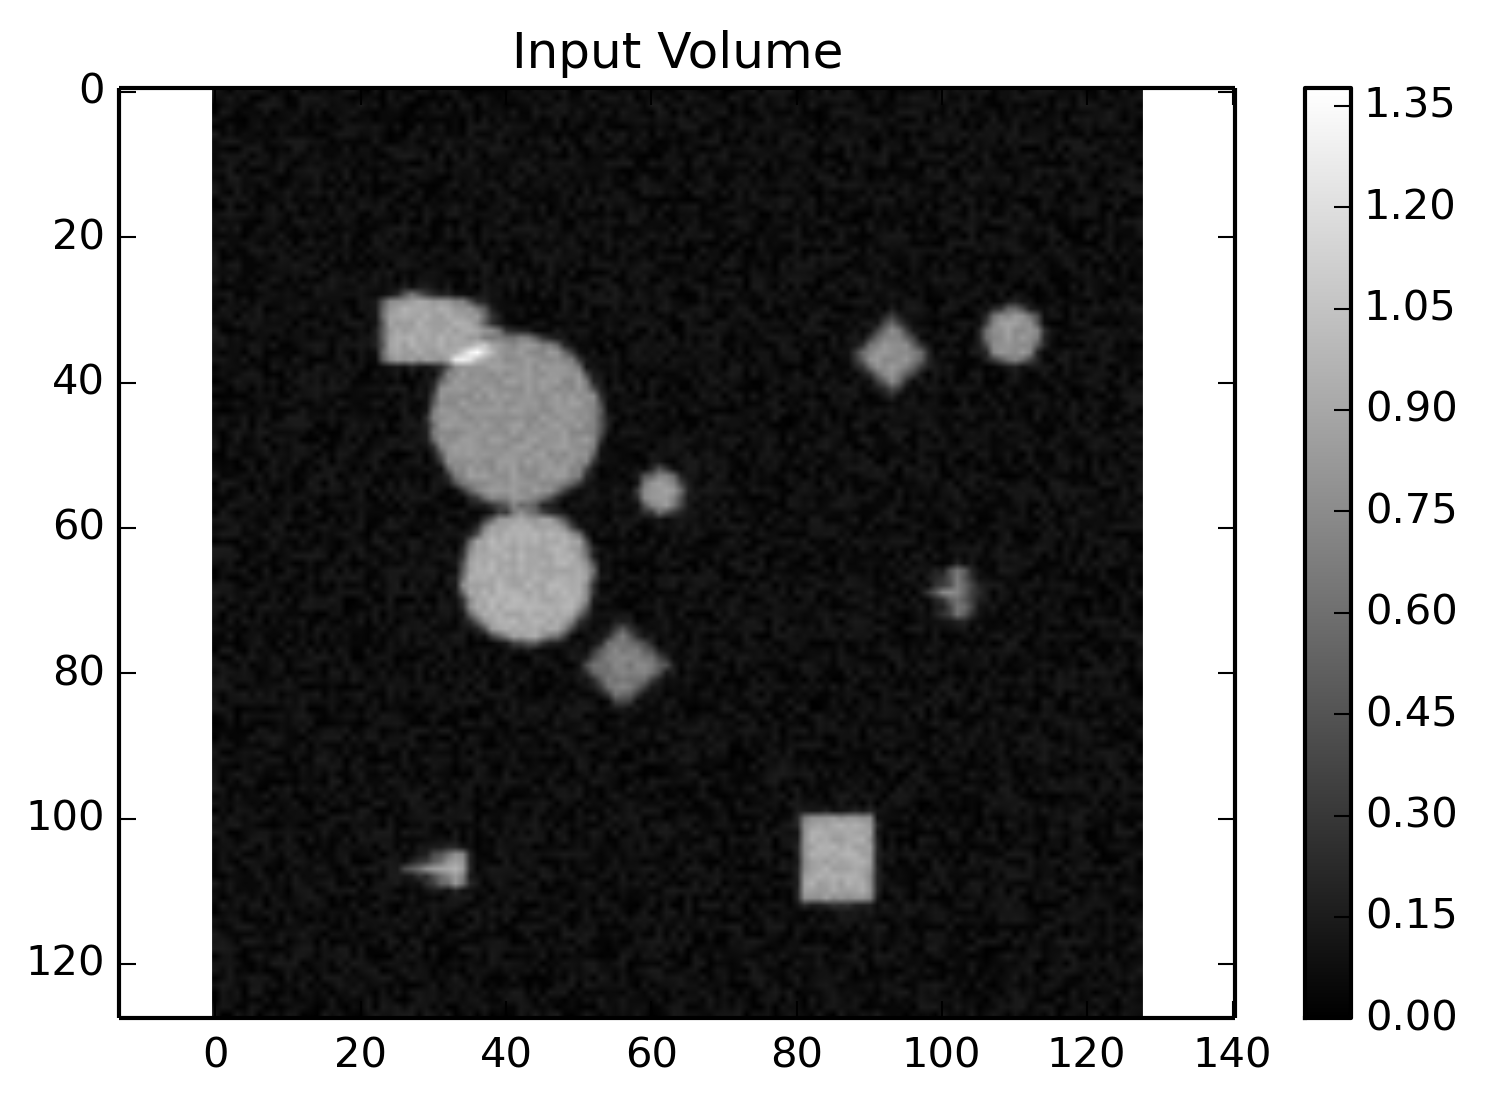

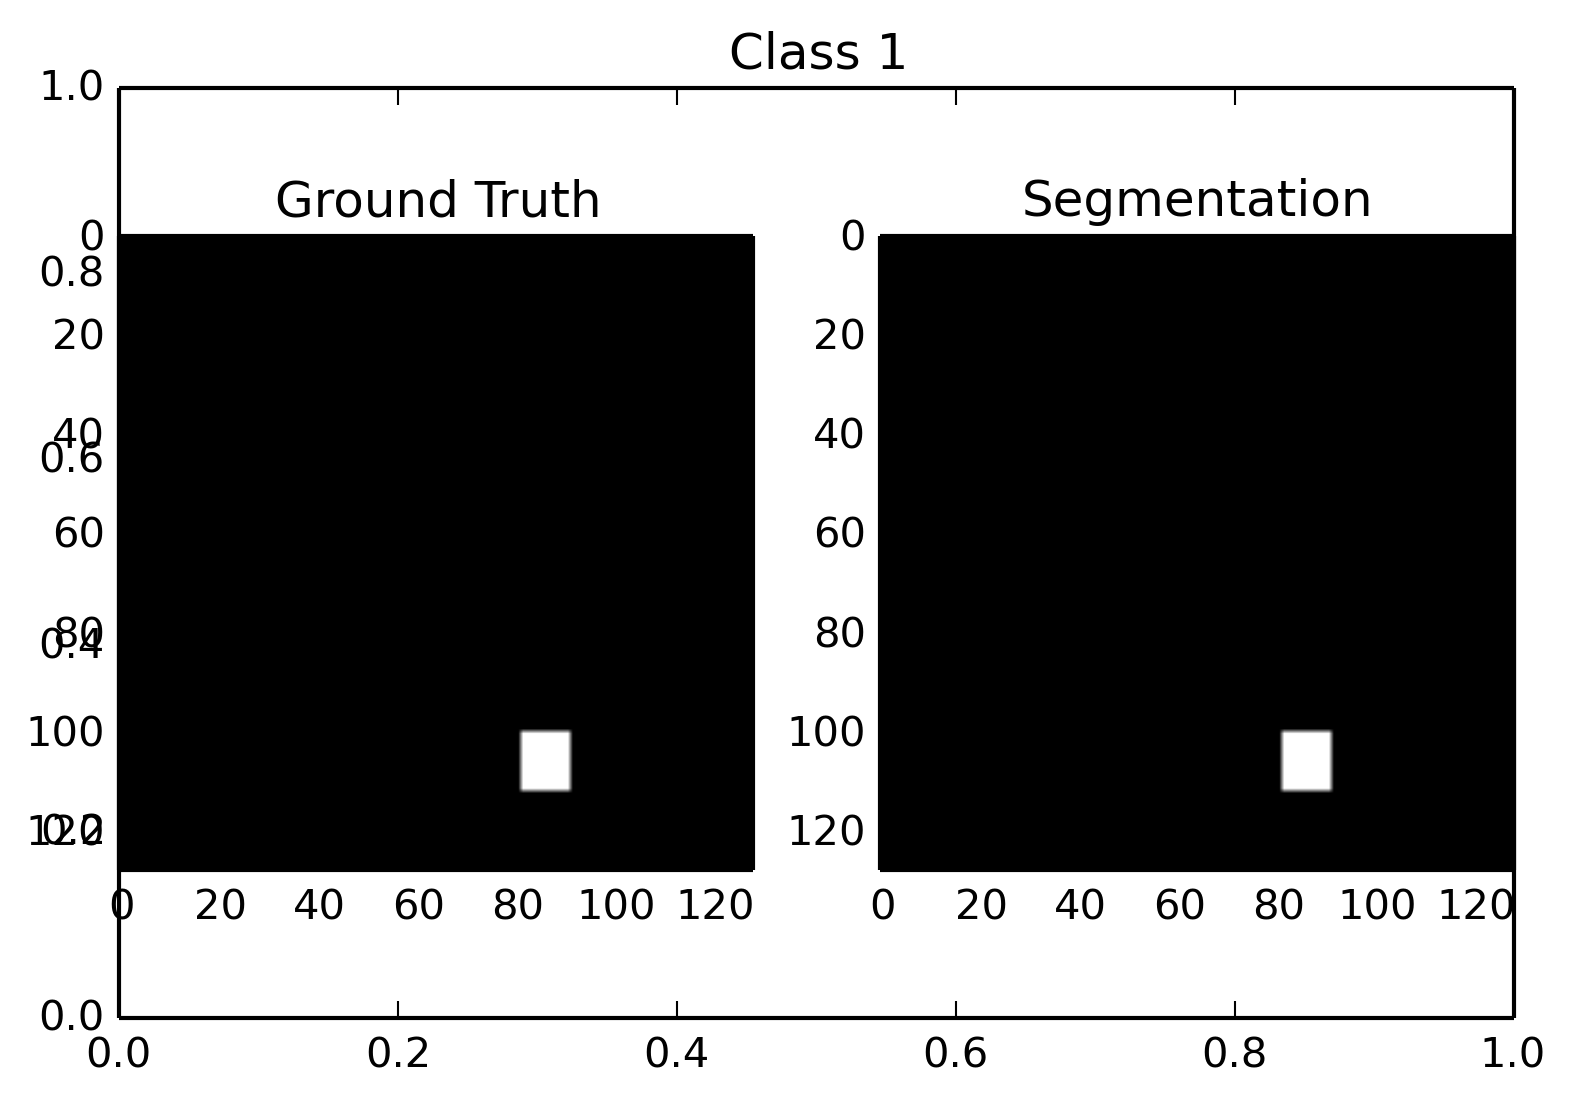

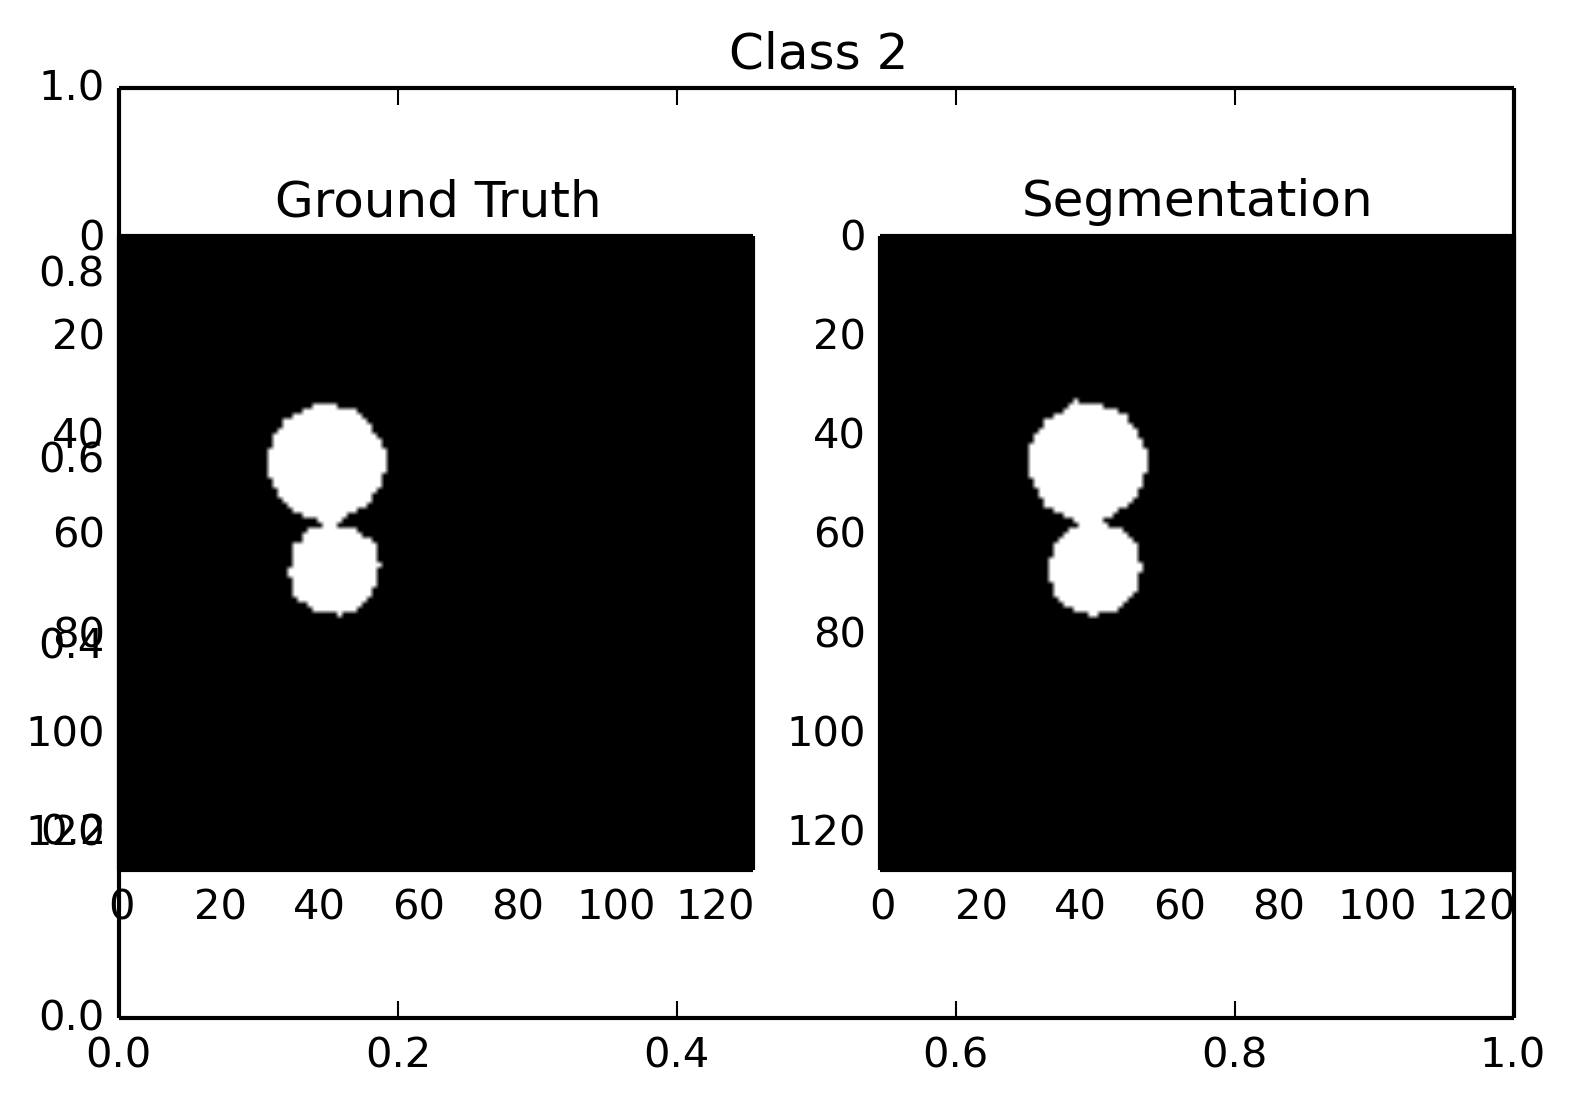

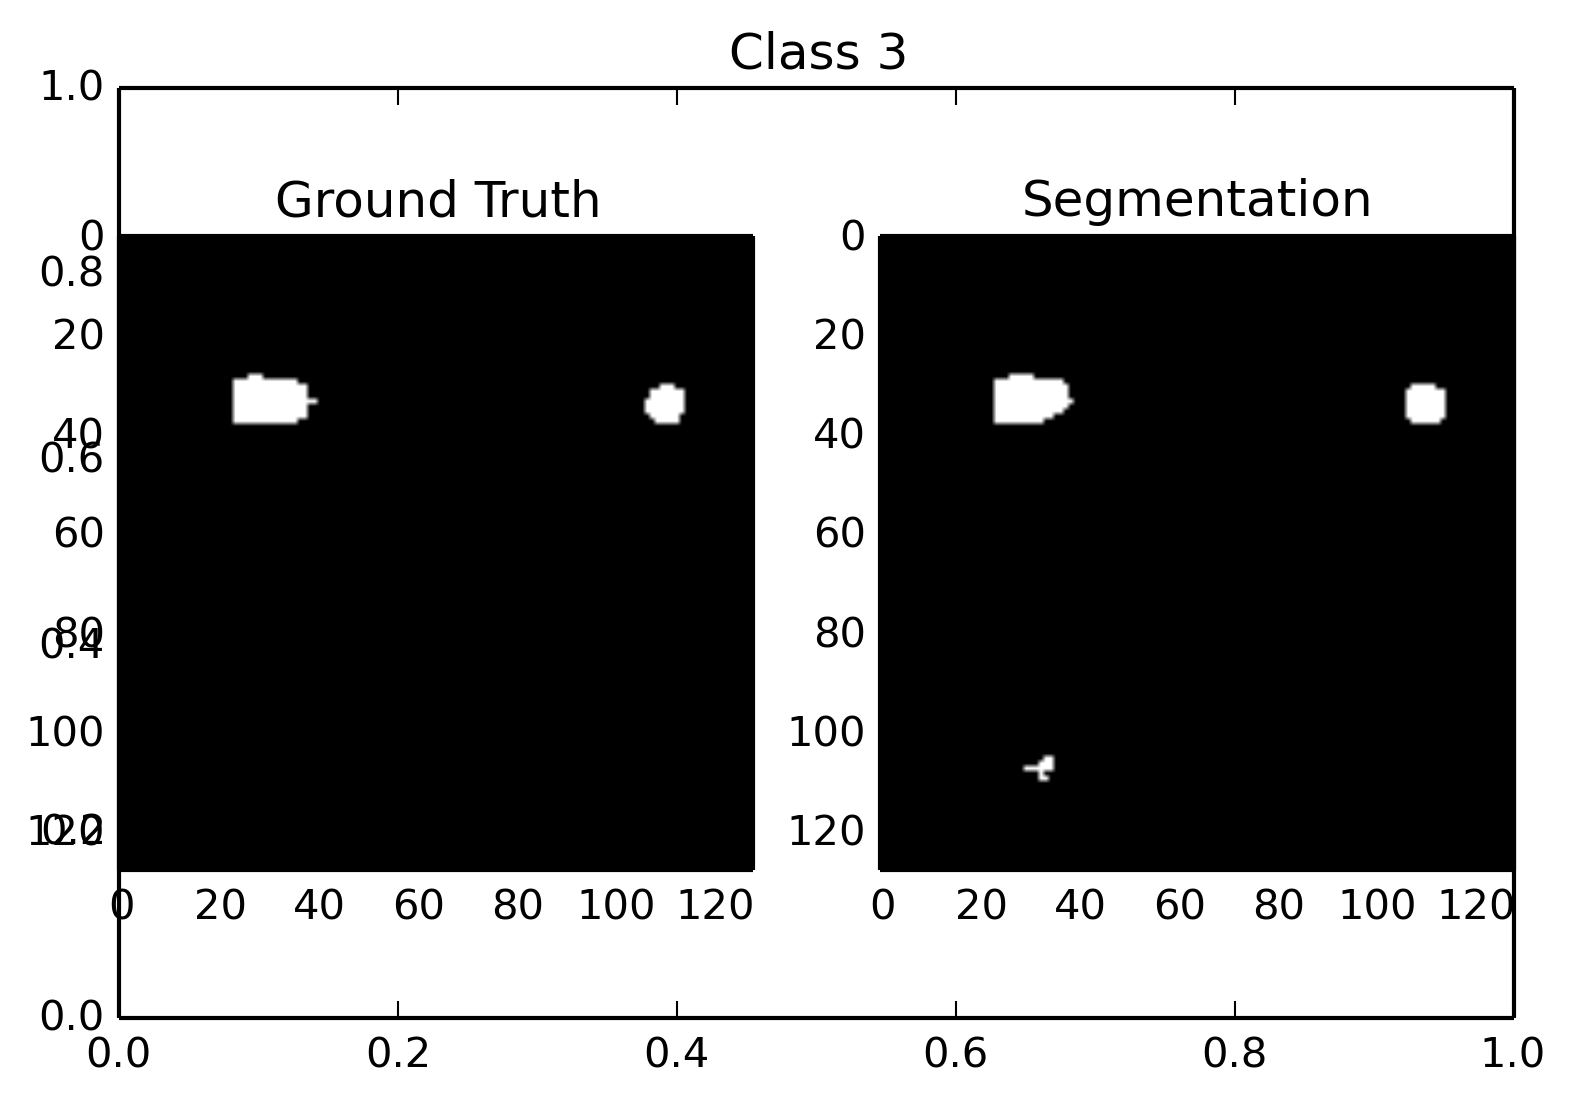

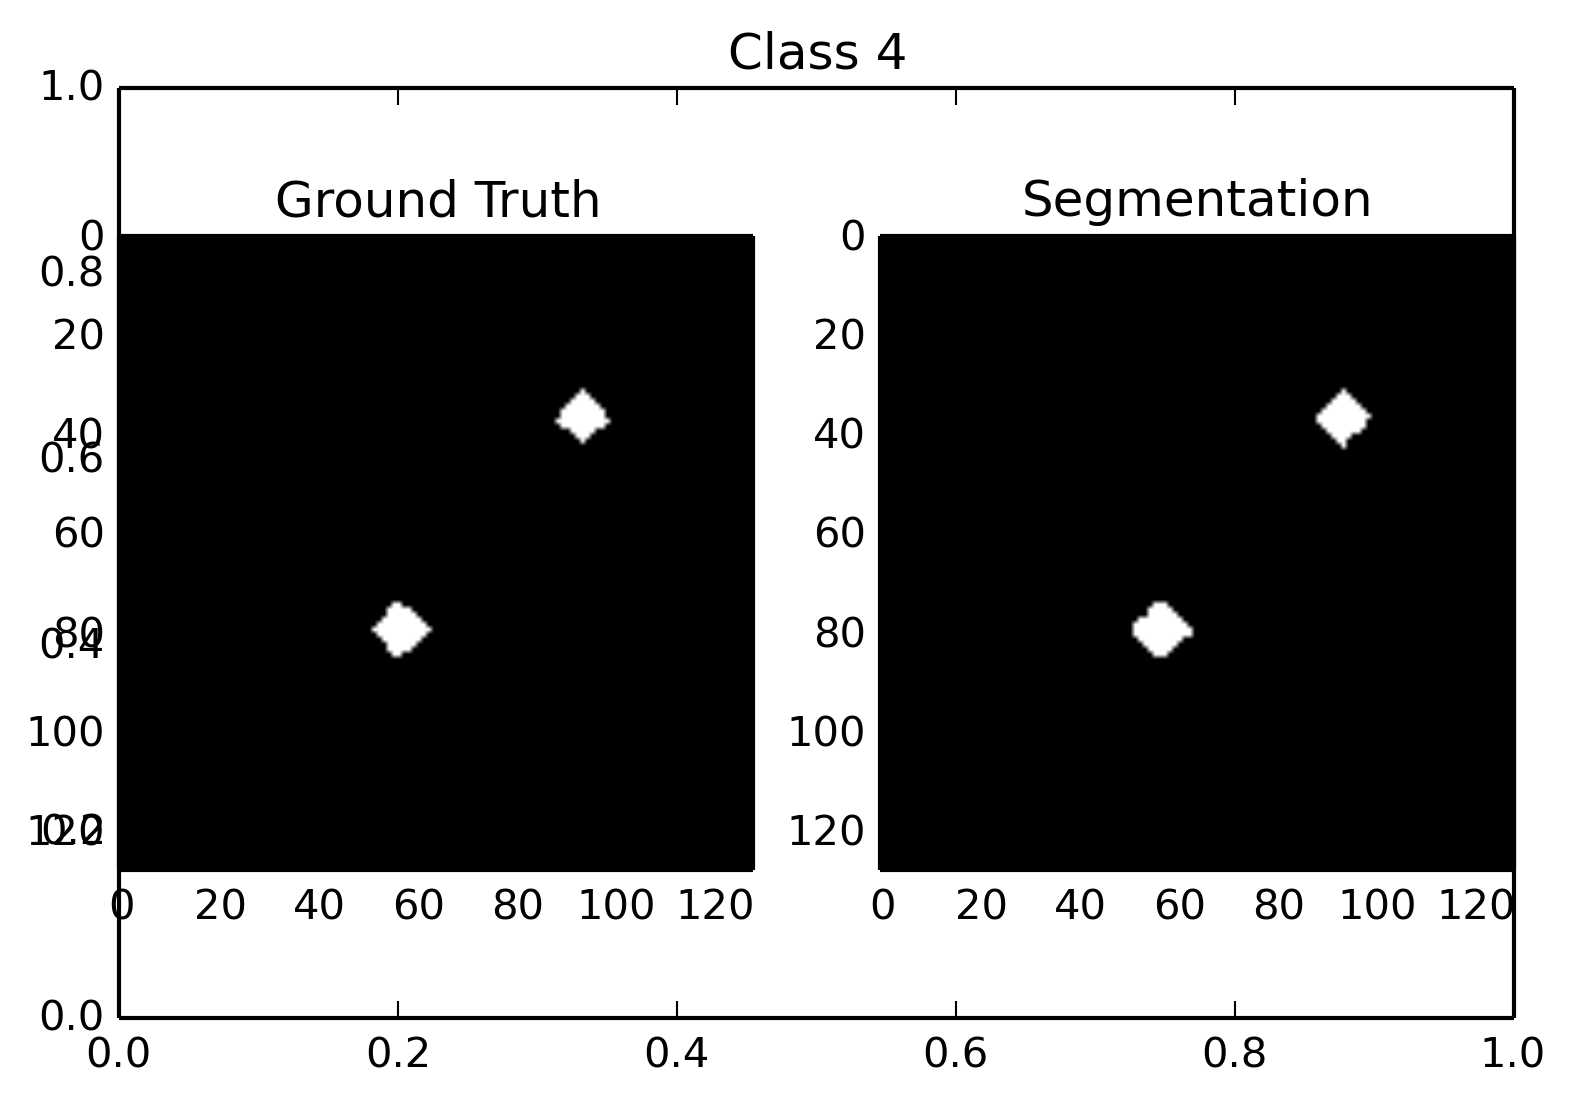

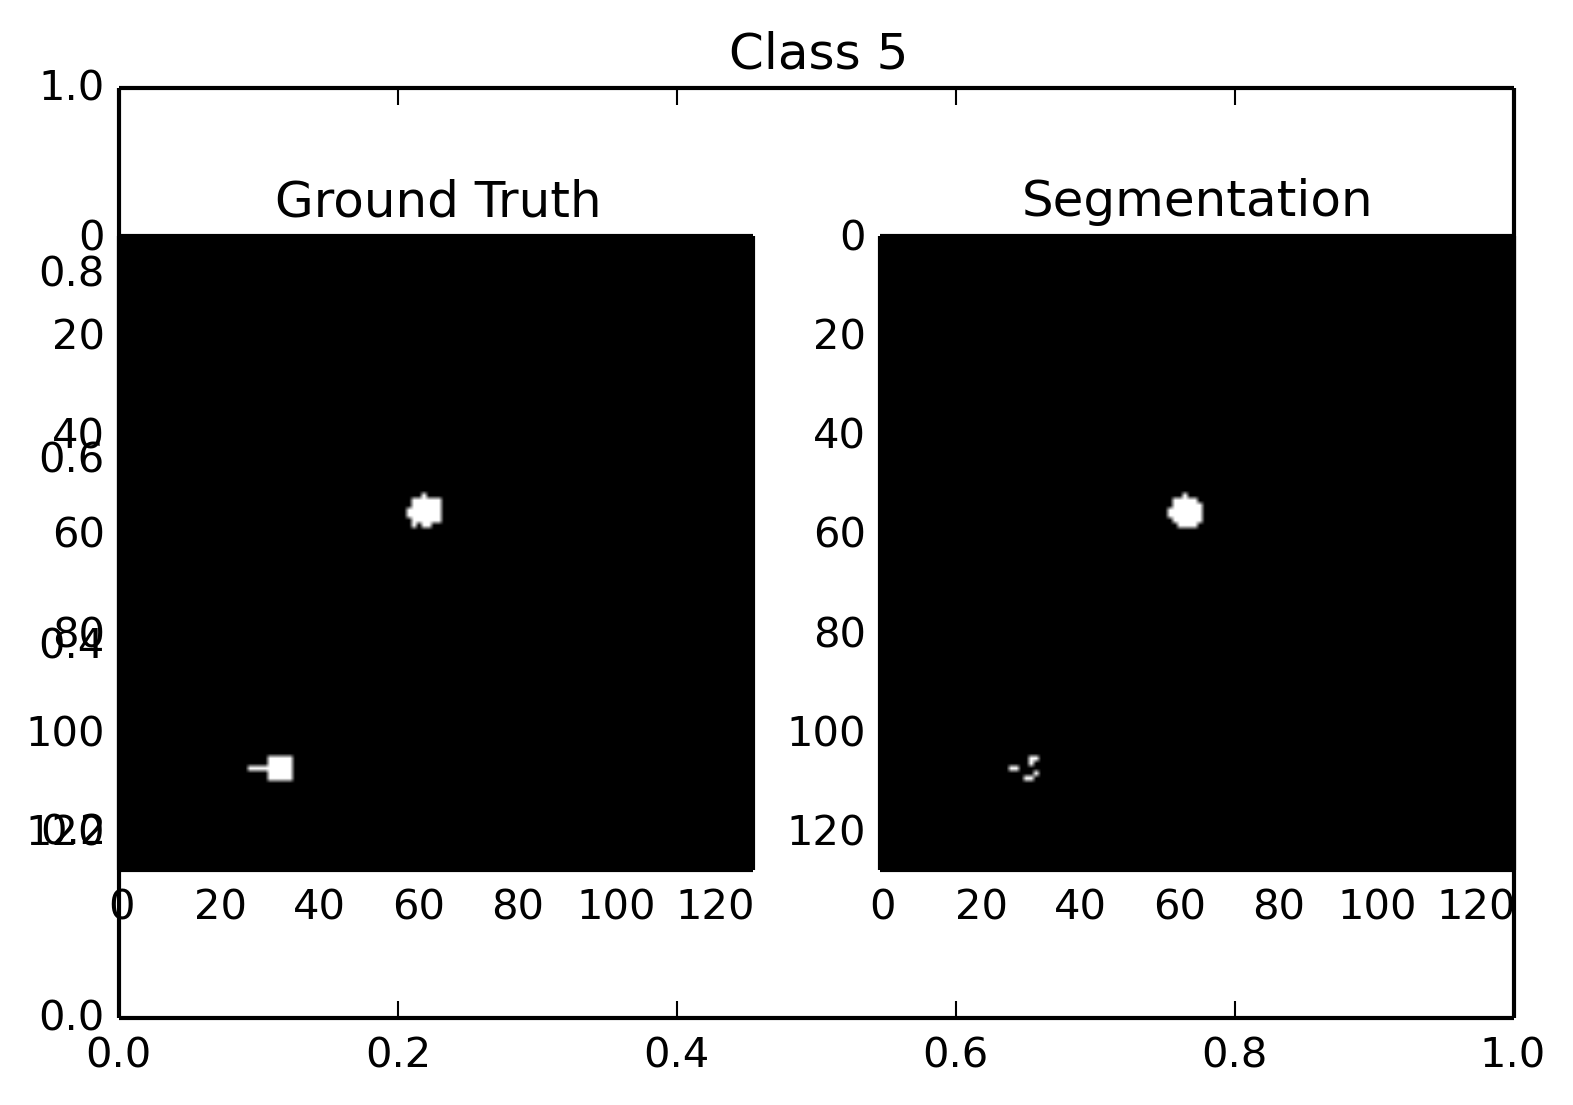

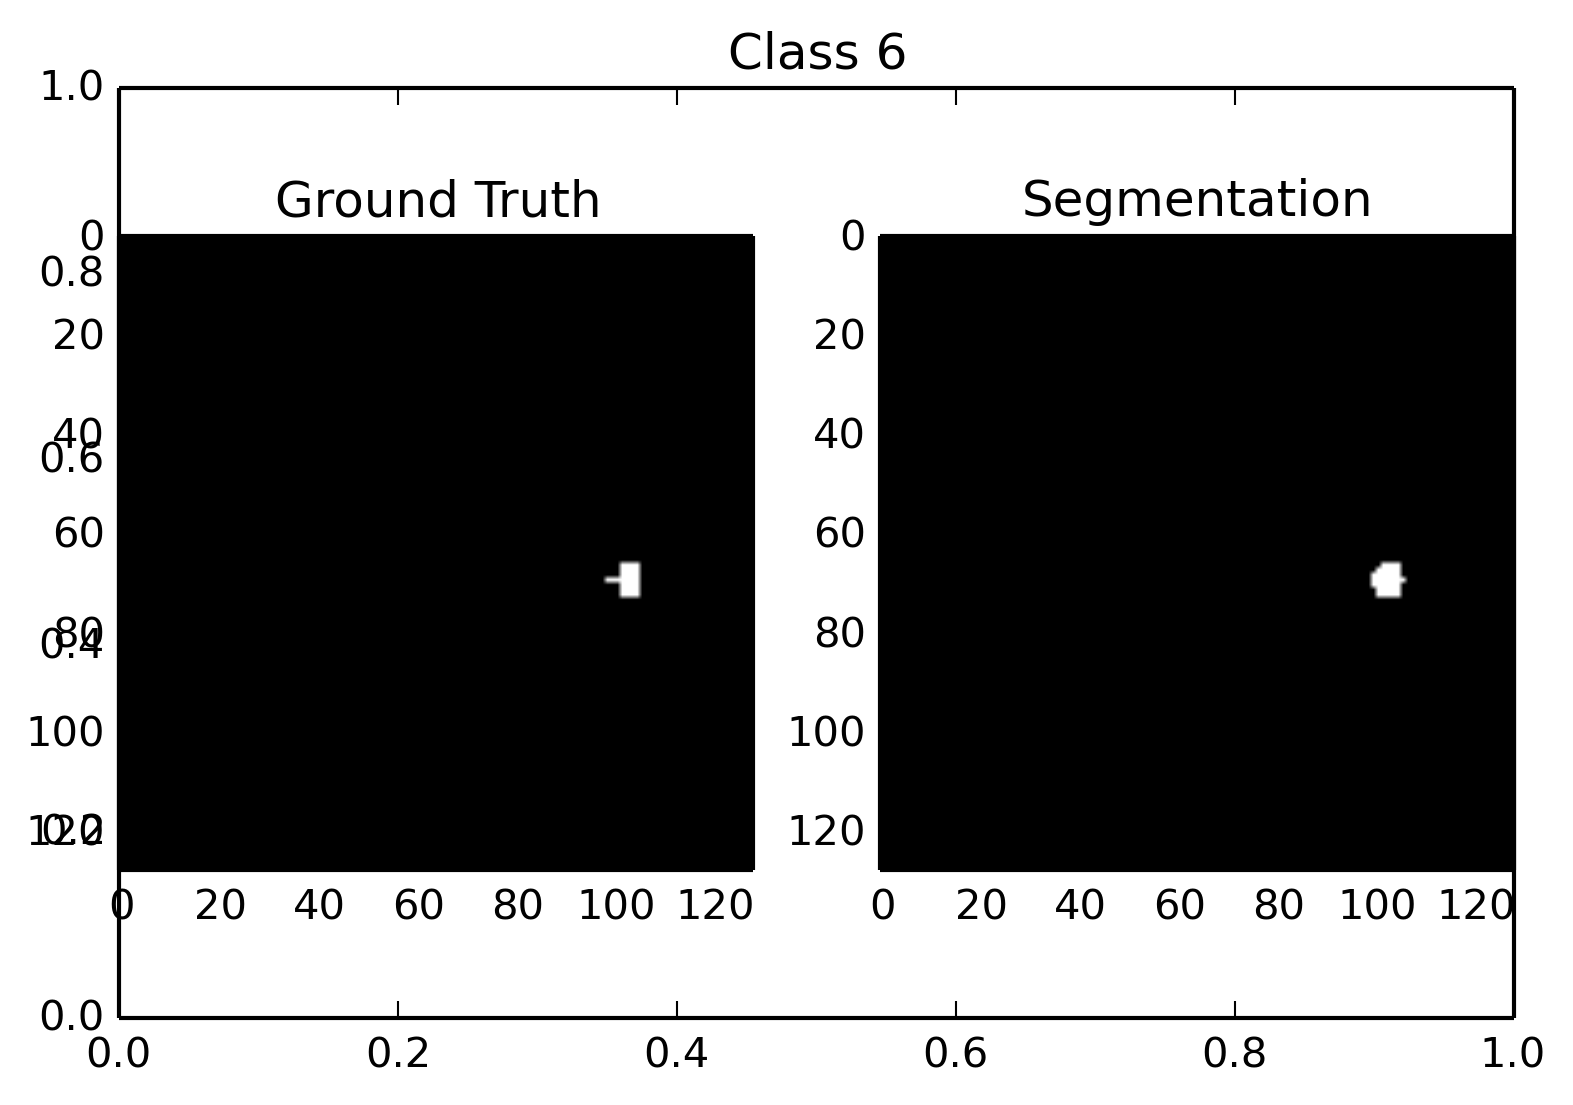

In [32]:
# Slice to plot
slice_use = 16



# Input Volume
plt.figure(dpi=300)
plt.title("Input Volume")
plt.axes().set_aspect('equal', 'datalim') # Mantiene aspect ratios
plt.set_cmap(plt.gray())
plt.imshow(batch_in[0,:, :, slice_use])
plt.colorbar()
plt.show()


# Class 1
fig = plt.figure(dpi=300)
plt.title("Class 1")
ax = fig.add_subplot(121)
ax.imshow(batch_label_int[0,:, :, slice_use,1])
ax.set_title("Ground Truth")
ax = fig.add_subplot(122)
ax.imshow(Cube_out_max[0,:, :, slice_use,1])
ax.set_title("Segmentation")

# Class 2
fig = plt.figure(dpi=300)
plt.title("Class 2")
ax = fig.add_subplot(121)
ax.imshow(batch_label_int[0,:, :, slice_use,2])
ax.set_title("Ground Truth")
ax = fig.add_subplot(122)
ax.imshow(Cube_out_max[0,:, :, slice_use,2])
ax.set_title("Segmentation")

# Class 3
fig = plt.figure(dpi=300)
plt.title("Class 3")
ax = fig.add_subplot(121)
ax.imshow(batch_label_int[0,:, :, slice_use,3])
ax.set_title("Ground Truth")
ax = fig.add_subplot(122)
ax.imshow(Cube_out_max[0,:, :, slice_use,3])
ax.set_title("Segmentation")

# Class 4
fig = plt.figure(dpi=300)
plt.title("Class 4")
ax = fig.add_subplot(121)
ax.imshow(batch_label_int[0,:, :, slice_use,4])
ax.set_title("Ground Truth")
ax = fig.add_subplot(122)
ax.imshow(Cube_out_max[0,:, :, slice_use,4])
ax.set_title("Segmentation")

# Class 5
fig = plt.figure(dpi=300)
plt.title("Class 5")
ax = fig.add_subplot(121)
ax.imshow(batch_label_int[0,:, :, slice_use,5])
ax.set_title("Ground Truth")
ax = fig.add_subplot(122)
ax.imshow(Cube_out_max[0,:, :, slice_use,5])
ax.set_title("Segmentation")

# Class 6
fig = plt.figure(dpi=300)
plt.title("Class 6")
ax = fig.add_subplot(121)
ax.imshow(batch_label_int[0,:, :, slice_use,6])
ax.set_title("Ground Truth")
ax = fig.add_subplot(122)
ax.imshow(Cube_out_max[0,:, :, slice_use,6])
ax.set_title("Segmentation")





### Perspective visualizations

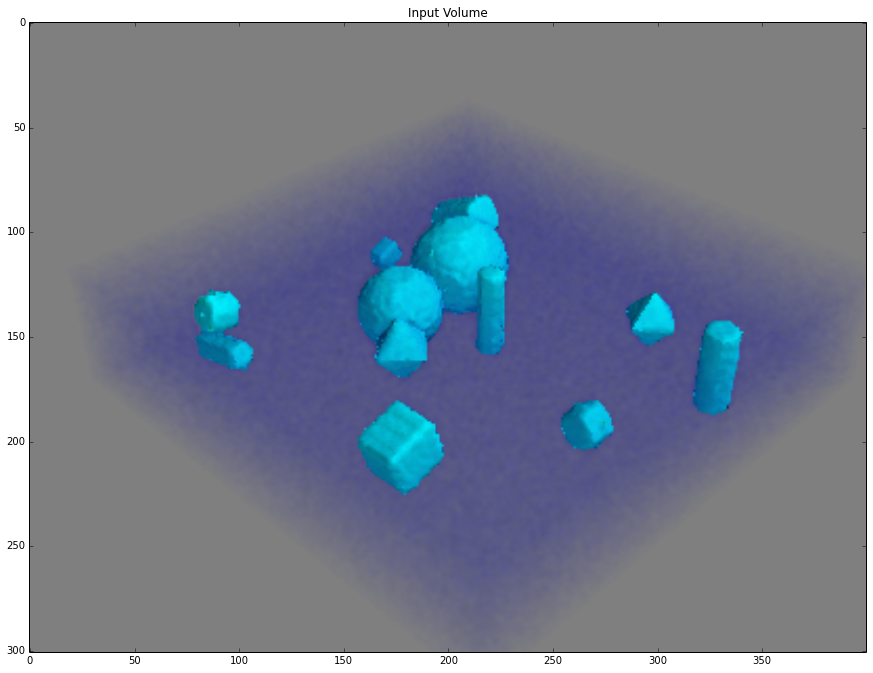

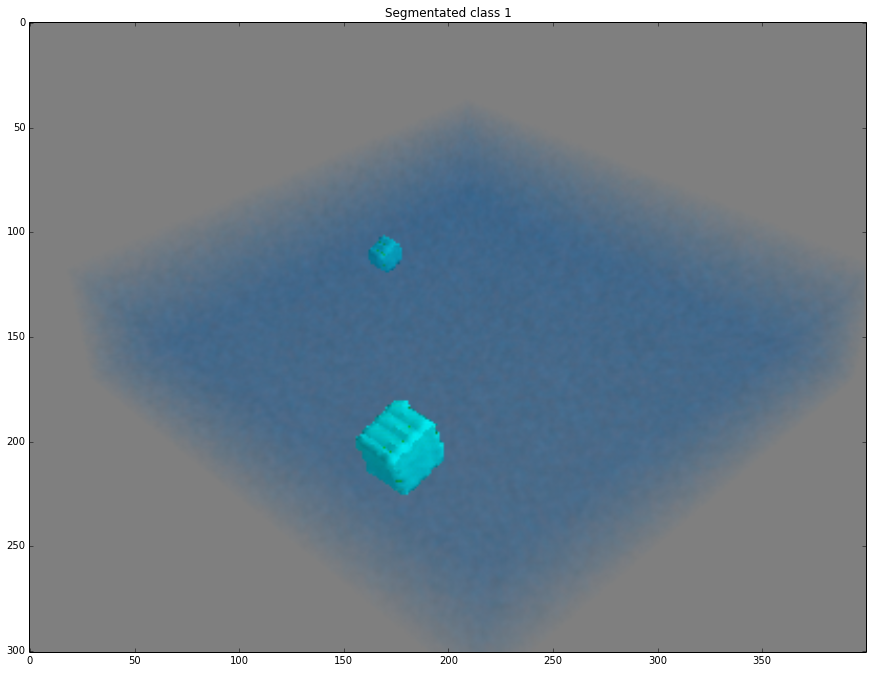

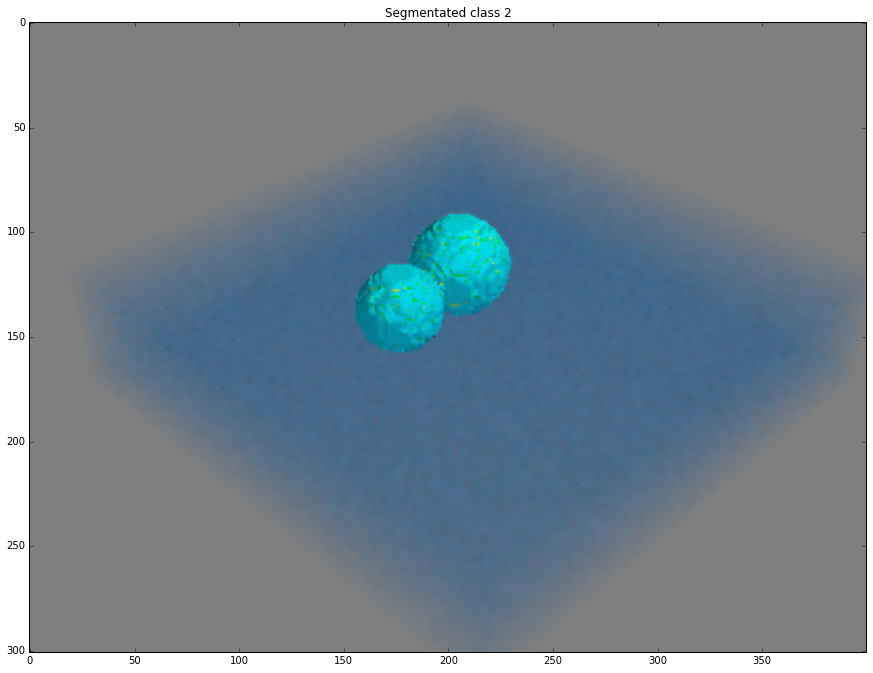

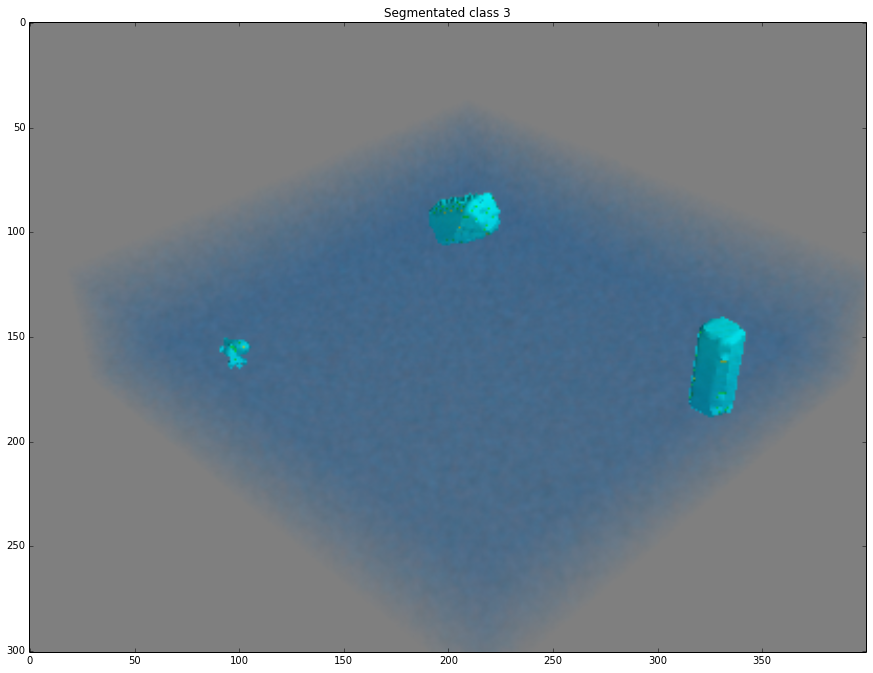

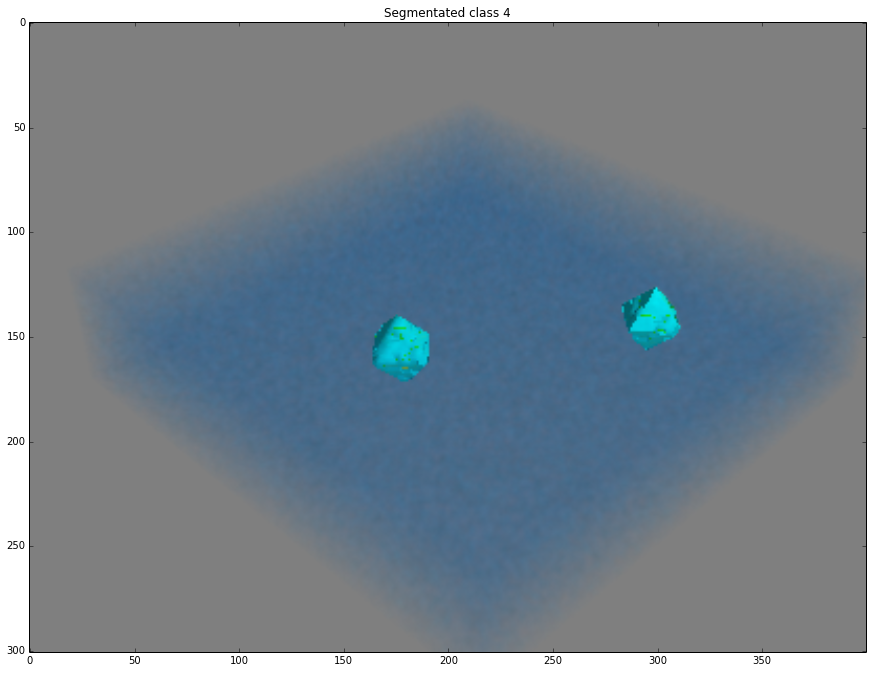

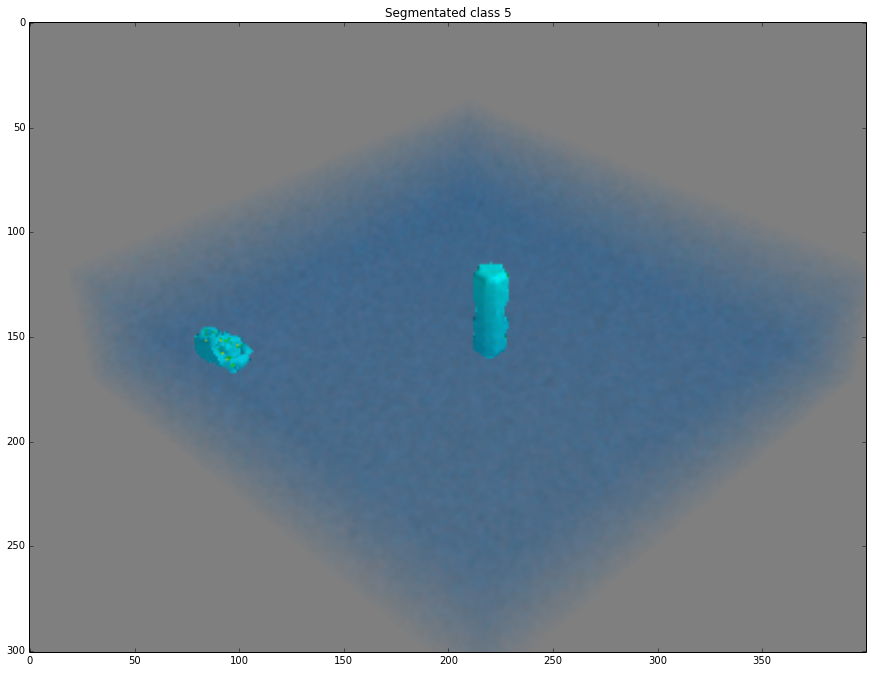

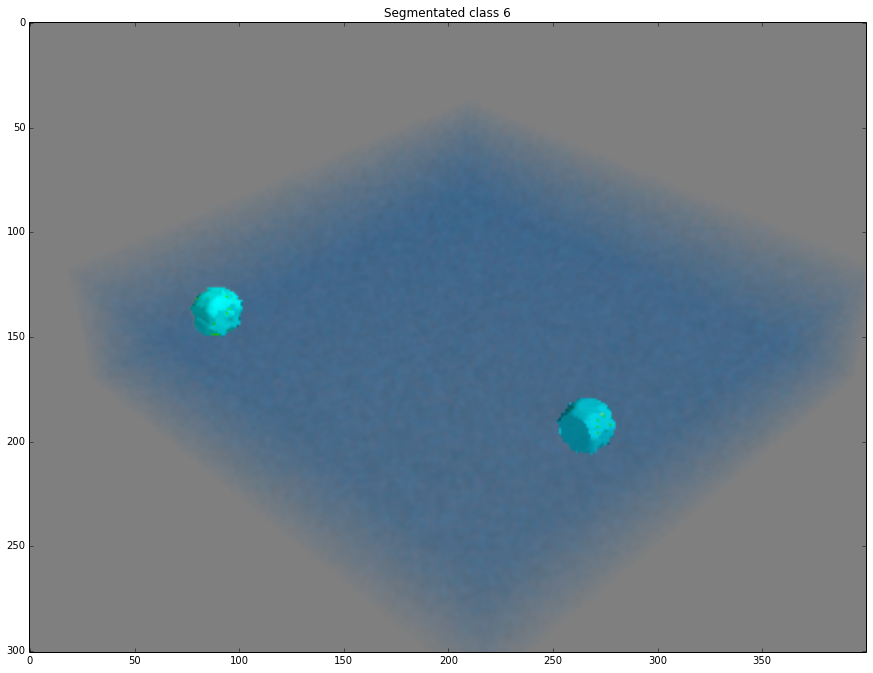

In [35]:
# Input pespective
Cubo_out = batch_in[0,:, :, :]
# Mayavi 
Cubo_out[0,0,0] = 0 # Para mantener el coloreado
mlab.contour3d(Cubo_out)
mlab.pipeline.volume(mlab.pipeline.scalar_field(Cubo_out))
# Take screenshot
arr = mlab.screenshot()
# Get current view
cam_view_point = mlab.view()
mlab.close()
# Plot
fig = plt.figure(figsize=(15, 15))
pylab.imshow(arr)
plt.title("Input Volume")
plt.show()


# Classes pespective
for i in range(1,num_clases):
    Cubo_out = Cube_out_max[0,:, :, :,i]
    # Mayavi 
    Cubo_out[0,0,0] = 0 # Para mantener el coloreado
    # Noise addition, just for generate a FoV with mlab
    vol_noise = np.random.rand(voxels_X, voxels_Y, voxels_Z)
    vol_noise = np.multiply(vol_noise, noise_max)
    Cubo_out += vol_noise
    mlab.contour3d(Cubo_out)
    mlab.pipeline.volume(mlab.pipeline.scalar_field(Cubo_out))
    # Set viewpoint
    mlab.view(*cam_view_point)
    # Take screenshot
    arr = mlab.screenshot()
    mlab.close()
    # Plot
    fig = plt.figure(figsize=(15, 15))
    pylab.imshow(arr)
    plt.title("Segmentated class %d"%i)
    plt.show()
    


### 3D Visualization - Mayavi

In [34]:
# Cant open multiple classes at the same time, it blocks the notebook

# Clases
# Cubo_out = Cube_out_max[0,:, :, :,5]
# Input
Cubo_out = batch_in[0,:, :, :]

# Mayavi visualization
Cubo_out[0,0,0] = 0 # Para mantener el coloreado
mlab.contour3d(Cubo_out)
mlab.pipeline.volume(mlab.pipeline.scalar_field(Cubo_out))

mlab.show()
